# Part II - Explanatory analyze of Bike-sharing data
## by Evgeniy Kuryan


## Investigation Overview

Questions to this data that need to be answered:
1. When are most trips taken in terms day of the week, number of week or month of the year
2. How long does the average trip take?
3. Does the above depend on if a user is a subscriber or customer?
4. Which stations are most highly loaded and which are not?

## Dataset Overview

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. Original data have 183412 rows and 16 columns with information: 'duration_sec', 'start_time', 'end_time', 'start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_name','end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type', 'member_birth_year', 'member_gender', 'bike_share_for_all_trip'.
There are some mistakes in data such as wrong birth data for subscribers, but they are not crucial for our observations.



In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df= pd.read_csv('201902-fordgobike-tripdata.csv')
df['start_time'] = pd.to_datetime(df['start_time'])
df['start_day'] = df.start_time.dt.day_name()
df['start_date'] = df.start_time.dt.date
df['end_date'] = df.start_time.dt.date
df['end_time'] = pd.to_datetime(df['end_time'])
df['end_day'] = df.end_time.dt.day_name()
df.end_day = df.end_day.astype('category')
df.start_day = df.start_day.astype('category')
df['start_week_num'] = df.start_time.dt.isocalendar().week
df['end_week_num'] = df.end_time.dt.isocalendar().week

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## (Visualization 1)

All trips were started in February 2019. 16 trips started in February and were completed in March 2019. Most rides were done at week number 8. In our data, we have complete information about 3 weeks (week number 6,7,8), weeks 5 and 9 represented partly.

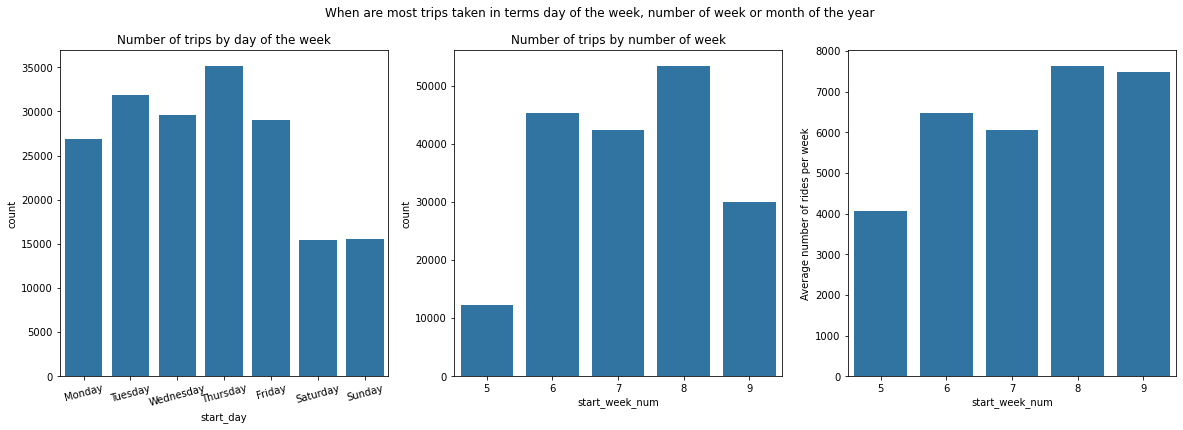

In [3]:
plt.figure(figsize=(20,6))
plt.suptitle("When are most trips taken in terms day of the week, number of week or month of the year");

plt.subplot(1,3,1)
color = sns.color_palette()[0]
order = ['Monday',  'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data = df, x= 'start_day', order = order,color = color);
plt.xticks(rotation = 15);
plt.title('Number of trips by day of the week');

plt.subplot(1,3,2)
sns.countplot(data = df, x = 'start_week_num',color = color);
plt.title('Number of trips by number of week');

rides_per_weeek = df.groupby(['start_week_num'])['start_date'].count()/df.groupby(['start_week_num'])['start_date'].nunique()

plt.subplot(1,3,3)
sns.barplot(x=rides_per_weeek.index, y = rides_per_weeek,color = color);
plt.ylabel('Average number of rides per week');

## (Visualization 2)
Almost 90% of rides was done by subscribers (exact value = 89,17%)

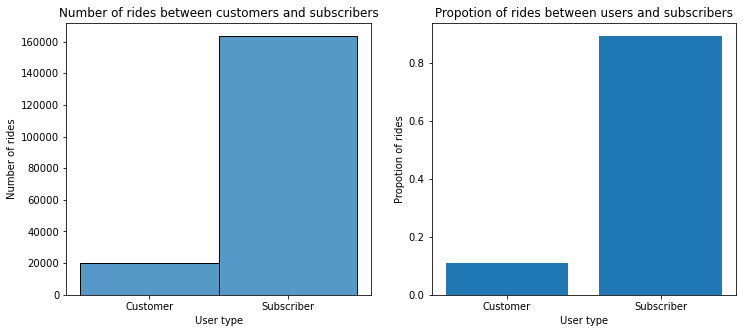

In [4]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df.user_type);
plt.title('Number of rides between customers and subscribers');
plt.xlabel('User type');
plt.ylabel('Number of rides');

plt.subplot(1,2,2)
proportion = df['user_type'].value_counts(normalize=True).sort_values()
plt.bar(proportion.index,proportion);
plt.title('Propotion of rides between users and subscribers');
plt.ylabel('Propotion of rides');
plt.xlabel('User type');

## (Visualization 3)
Average duration for subscriber trip is 640 second, and for Customer: 1432 seconds. Average duration of trip at all is 726 seconds.

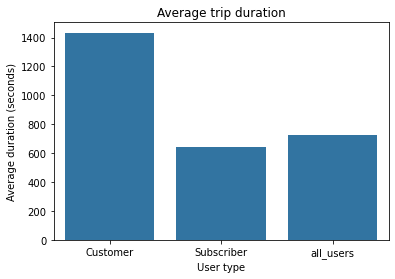

In [5]:
avg = df.groupby(['user_type'])['duration_sec'].mean()
avg['all_users'] = df['duration_sec'].mean()
sns.barplot(x = avg.index, y = avg,color=color);
plt.title('Average trip duration');
plt.ylabel('Average duration (seconds)');
plt.xlabel('User type');

## (Visualization 4)
The average trip duration on weekends is higher than on weekdays. Our customers prefer long trips on weekends, but the duration of the trips for subscribers is practically independent of weekends or weekdays. Also, there are practically no relations between the number of rides and day of the week for our customers, but our subscribers mostly use our bikes on weekdays. This information can be used in planning a marketing campaign to increase the use of our bicycles on unloaded days.



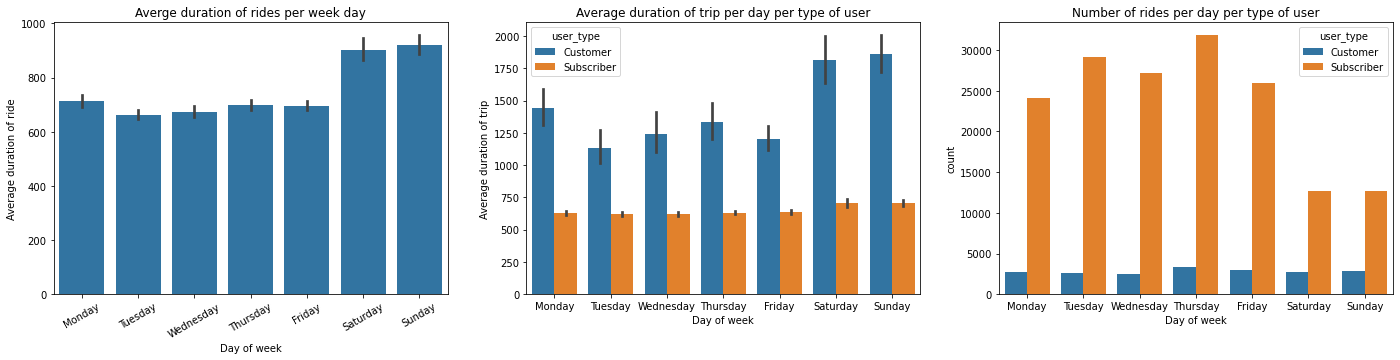

In [6]:
plt.figure(figsize=(24,5))
plt.subplot(1,3,1)
sns.barplot(data = df, x = 'start_day',y='duration_sec',color=color, order = order);
plt.xticks(rotation = 30);
plt.ylabel('Average duration of ride');
plt.xlabel('Day of week');
plt.title('Averge duration of rides per week day');

plt.subplot(1,3,2)
sns.barplot(data = df, x = 'start_day', y = 'duration_sec',hue = 'user_type', order = order);
plt.ylabel('Average duration of trip');
plt.title('Average duration of trip per day per type of user');
plt.xlabel('Day of week');

plt.subplot(1,3,3)
sns.countplot(data = df, x = 'start_day', hue = 'user_type', order = order);
plt.title('Number of rides per day per type of user');
plt.xlabel('Day of week');

In [7]:
top_start_loc = list(df.start_station_name.value_counts()[:7].index)
top_end_loc = list(df.end_station_name.value_counts()[:7].index)
low_start_loc = list(df.start_station_name.value_counts()[-7:].index)
low_end_loc = list(df.end_station_name.value_counts()[-7:].index)
list_of_loc = [top_start_loc,top_end_loc,low_start_loc,low_end_loc]

df_start_station = df.groupby(['start_date','start_station_name'])['duration_sec'].count().reset_index() #let's count how much starts from each station was done in each day
df_start_station.rename(columns = {'duration_sec':'number_of_starts','start_station_name':'station_name','start_date':'date'},inplace = True) #rename columns to merge them in one data frame in future

df_end_station = df.groupby(['end_date','end_station_name'])['duration_sec'].count().reset_index() #same for finishes
df_end_station.rename(columns = {'duration_sec':'number_of_finishes','end_station_name':'station_name','end_date':'date'},inplace = True)

stations_usage = pd.merge(df_start_station,df_end_station,how='outer',left_on=['date','station_name'],right_on=['date','station_name'])
stations_usage[['number_of_starts','number_of_finishes']] = stations_usage[['number_of_starts','number_of_finishes']].fillna(0)
stations_usage.date = pd.to_datetime(stations_usage.date)
stations_usage['day'] = stations_usage.date.dt.day_name()
stations_usage['day_load'] = stations_usage['number_of_starts'] + stations_usage['number_of_finishes']
stations_usage[['number_of_starts','number_of_finishes','day_load']] = stations_usage[['number_of_starts','number_of_finishes','day_load']].astype('int')
stations_usage.day = stations_usage.day.astype('category')

low_usage = list(stations_usage.groupby(['station_name'])['day_load'].sum().sort_values().index[:7])
top_usage = list(stations_usage.groupby(['station_name'])['day_load'].sum().sort_values().index[-7:])


## Visualization 5
Important information for business decisions. On average, 200–350 uses of the busiest stations on weekdays, 50–150 - on weekends.

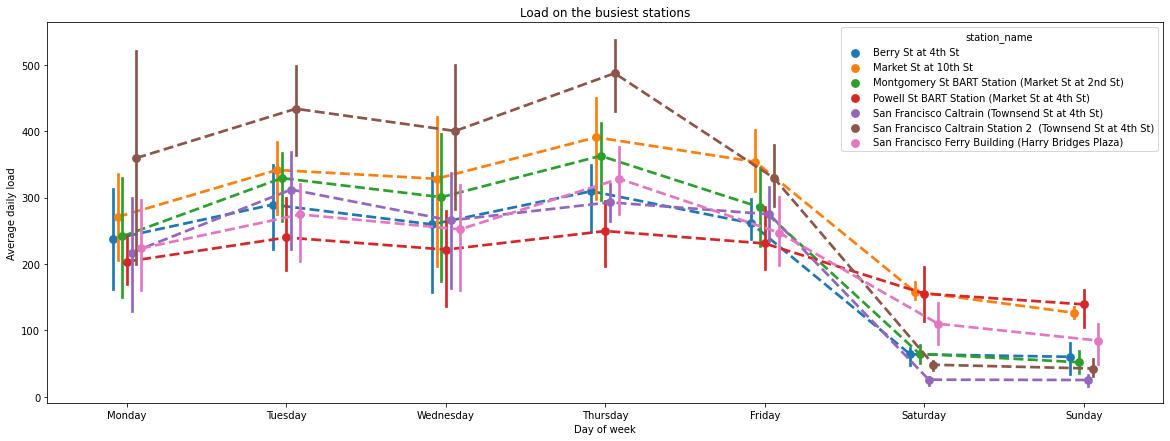

In [8]:

plt.figure(figsize=(20,7))
sns.pointplot(data = stations_usage[stations_usage.station_name.isin(top_usage)],x = 'day',y='day_load',hue = 'station_name',dodge = True,order = order,linestyles = '--');
plt.xlabel('Day of week');
plt.ylabel('Average daily load');
plt.title('Load on the busiest stations');

In [9]:
stations_usage = pd.merge(stations_usage, df[['start_station_name','start_station_longitude','start_station_latitude']].drop_duplicates(),how='left',left_on=['station_name'],right_on=['start_station_name'])
stations_usage.rename(columns={'start_station_latitude':'station_latitude','start_station_longitude':'station_longitude'},inplace=True)
stations_usage.drop(columns=['start_station_name'],inplace=True)

stations_load = stations_usage.groupby(['station_name','station_longitude','station_latitude'])['day_load'].sum().reset_index()
stations_load.rename(columns = {'day_load':'month_load'},inplace = True)
stations_load['avg_day_load'] = stations_load.month_load/stations_usage.date.nunique()

## Visualization 6.1
Let's see the locations of our station, their monthly load, and how they could be grouped by the location.

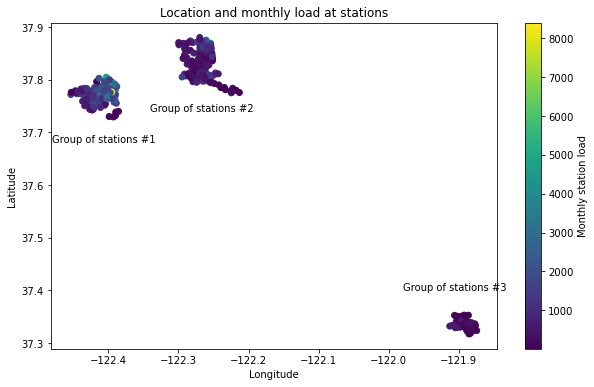

In [10]:
plt.figure(figsize=(10,6))
plt.scatter(data = stations_load,x = 'station_longitude', y = 'station_latitude',c='month_load');
plt.colorbar(label = 'Monthly station load');
plt.text(-122.48,37.68,'Group of stations #1');
plt.text(-122.34,37.74,'Group of stations #2');
plt.text(-121.98,37.4,'Group of stations #3');
plt.title('Location and monthly load at stations');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

### Visualization 6.2
The heavily loaded stations serve around 300 visits per day, while there are many stations with less than 4 visits per day. Let's see how it looks.

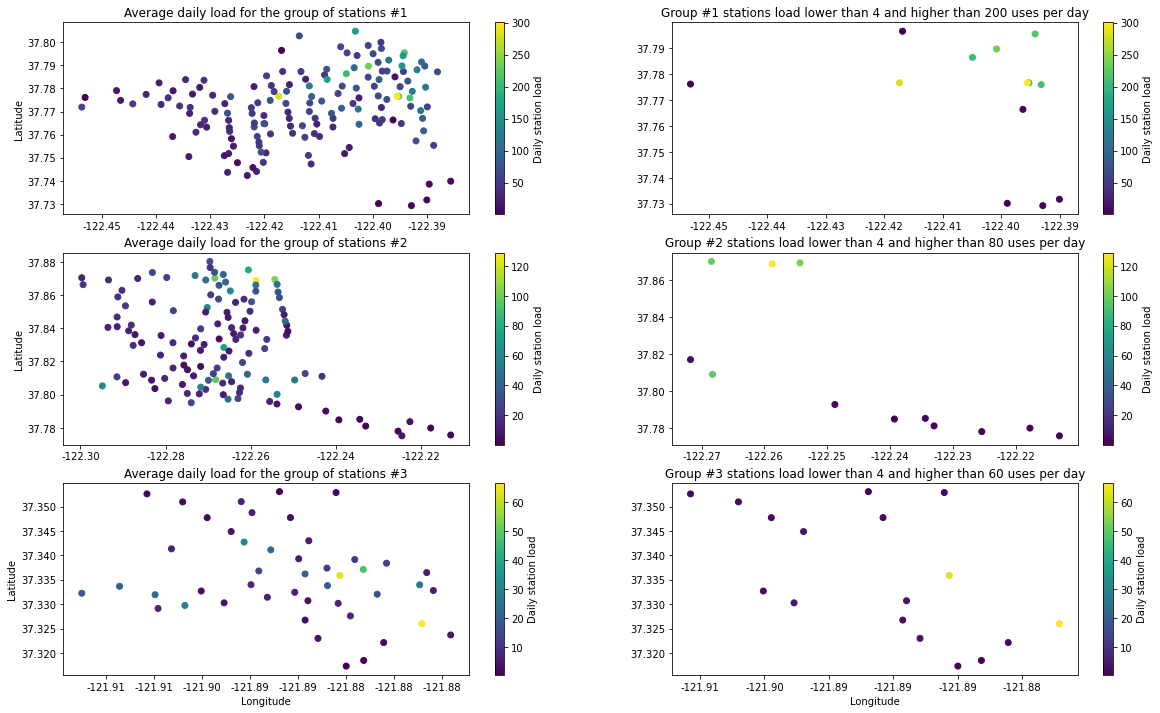

In [31]:
from matplotlib.ticker import StrMethodFormatter
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
plt.scatter(data = stations_load[stations_load.station_longitude<-122.3],x = 'station_longitude', y = 'station_latitude', c = 'avg_day_load',cmap= 'viridis');
plt.colorbar(label = 'Daily station load');
plt.title('Average daily load for the group of stations #1');
plt.ylabel('Latitude');
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'));

plt.subplot(3,2,2)
plt.scatter(data = stations_load[(stations_load.station_longitude<-122.3)&((stations_load.avg_day_load<4)|(stations_load.avg_day_load>200))],x = 'station_longitude', y = 'station_latitude', c = 'avg_day_load',cmap= 'viridis');
plt.colorbar(label = 'Daily station load');
plt.title('Group #1 stations load lower than 4 and higher than 200 uses per day');
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'));

plt.subplot(3,2,3)
plt.scatter(data = stations_load[(stations_load.station_longitude>-122.35) & (stations_load.station_longitude<-122.0)],x = 'station_longitude', y = 'station_latitude', c = 'avg_day_load',cmap= 'viridis');
plt.colorbar(label = 'Daily station load');
plt.title('Average daily load for the group of stations #2');
plt.ylabel('Latitude');
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'));

plt.subplot(3,2,4)
plt.scatter(data = stations_load[((stations_load.station_longitude>-122.35) & (stations_load.station_longitude<-122.0))&((stations_load.avg_day_load<4)|(stations_load.avg_day_load>80))],x = 'station_longitude', y = 'station_latitude', c = 'avg_day_load',cmap= 'viridis');
plt.colorbar(label = 'Daily station load');
plt.title('Group #2 stations load lower than 4 and higher than 80 uses per day');
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'));

plt.subplot(3,2,5)
plt.scatter(data = stations_load[stations_load.station_longitude>-122],x = 'station_longitude', y = 'station_latitude', c = 'avg_day_load',cmap= 'viridis');
plt.colorbar(label = 'Daily station load');
plt.title('Average daily load for the group of stations #3');
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'));

plt.subplot(3,2,6)
plt.scatter(data = stations_load[(stations_load.station_longitude>-122)&((stations_load.avg_day_load<4)|(stations_load.avg_day_load>60))],x = 'station_longitude', y = 'station_latitude', c = 'avg_day_load',cmap= 'viridis');
plt.colorbar(label = 'Daily station load');
plt.title('Group #3 stations load lower than 4 and higher than 60 uses per day');
plt.xlabel('Longitude');
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'));


>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [29]:
!jupyter nbconvert <Part_II_Filename>.ipynb --to slides --post serve --no-input --no-prompt

ЌҐ г¤ Ґвбп ­ ©вЁ гЄ § ­­л© д ©«.
